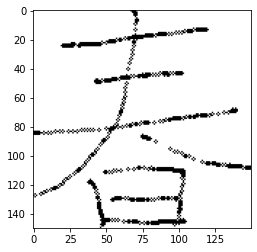

<Figure size 432x288 with 0 Axes>

In [1]:
""" 
1, 读取字体数据
"""

import numpy as np
import json
from PIL import Image
import matplotlib.pyplot as plt
import cv2
import os

image_size = (150, 150)


def data_read(file_path):
    """
    读取字体数据 
    """
    with open(file_path, 'r') as file:
        datas = json.loads(file.read())
        data = []
        for lines in datas:
            for point in lines:
                data.append(np.array(point))
        data = np.asarray(data)
    # print(data.shape)
    return data


def data_2_image(data):
    """
    坐标转换
    ---
    image_size(w,h), 显示图片尺寸
    point_max(x1,y1) , 触摸坐标最右上方坐标
    point_min(x2,y2) , 触摸坐标最左上方坐标
    point(x?,y?) , 需要被转换的触发坐标
    ---
    x = w * (x1 - x?) / (x1 - x2)
    y = h * (y? - y2) / (y1 - y2) 
    """
    # [ [x1,y1],[x2,y2],[x3,y3] ]
    data = np.delete(data, -1, axis=1)
    # 最大值，最小值
    max = np.max(data, axis=0)
    min = np.min(data, axis=0)
    img = np.ones([image_size[0], image_size[1], 3], dtype=np.uint8) * 255
    for point in data:
        x = image_size[0] * (max[0]-point[0]) / (max[0]-min[0])
        y = image_size[1] * (point[1]-min[1]) / (max[1]-min[1])
        pos = [int(y), int(x)]
        cv2.circle(img, pos, 1, color=(0, 0, 0))
    return img


def data_show_test(data_file):
    """
    显示图片数据 
    """
    data = data_read(data_file)
    image = data_2_image(data)
    image = Image.fromarray(image)
    image = image.rotate(-90)
    plt.imshow(image)
    plt.figure('image')
    # plt.axis('off')
    plt.show()


# 测试
data_show_test('data/绵.json')


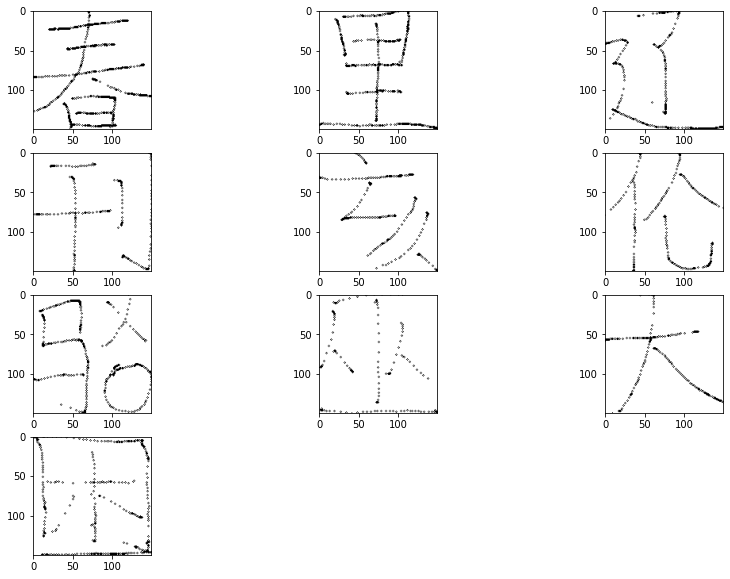

In [17]:
"""
2, 显示字体数据 
"""


def data_show_all():
    data_files = os.listdir('data')
    for index, data_file in enumerate(data_files):
        data = data_read(f'data/{data_file}')
        image = data_2_image(data)
        plt.subplot(6, 3, index+1)
        image = Image.fromarray(image)
        image = image.rotate(-90)
        plt.imshow(image)
        # plt.axis('off')
    plt.subplots_adjust(top=3, right=2)
    plt.show()


data_show_all()


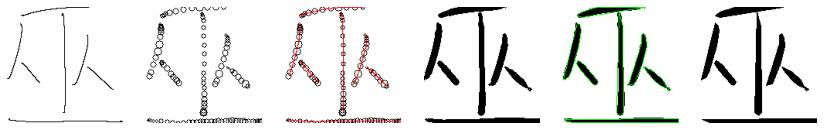

In [311]:
"""
3, 字体数据优化
---
参考案例：https://blog.csdn.net/luansxx/article/details/120960073
贝塞尔曲线
"""
import math
from math import factorial,sqrt

class HandWriting():

    def __init__(self,data_file):
        # 笔画数据
        self.strokes , self.points = self.__data_origin(data_file)
        # 笔锋处理

    def __data_origin(self,data_file):
        """
        数据：读取物理数据  
        """
        # 笔画数据
        strokes = []
        # 触点数据
        points = []
        with open(data_file, 'r') as file:
            datas = json.loads(file.read())
            for stroke in datas:
                strokes.append(np.array(stroke))
                for point in stroke:
                    points.append(point)
        return strokes , points
    
    def __data_screen(self,is_bezier=True):
        """ 
        数据：物理数据转换屏幕显示数据
        """
        # 显示坐标参数
        all_points = np.array(self.points)
        all_points = np.delete(all_points, -1, axis=1)
        max = np.max(all_points, axis=0)
        min = np.min(all_points, axis=0)
        # 数据转换
        screen_strokes = []
        for stroke in self.strokes:
            line = []
            # 压力值参数
            pressures = np.array(stroke)[:,2]
            pressures = pressures[pressures!=0]
            pressures_max = np.max(pressures)
            pressures_min = np.min(pressures)
            # 1.拟合点
            if is_bezier:
                stroke = self.__data_bezier(stroke) 
            # 遍历操作
            for point in stroke:
                # 2.物理坐标转换显示坐标
                # x = w * (x1 - x?) / (x1 - x2)
                # y = h * (y? - y2) / (y1 - y2) 
                x = image_size[0] * (max[0]-point[0]) / (max[0]-min[0])
                y = image_size[1] * (point[1]-min[1]) / (max[1]-min[1])
                # 3.压力值转换圆半径，归一化 * 3
                r = abs(int((point[2]-pressures_min)/(pressures_max-pressures_min)*5))
                pos = [y, x, r]
                line.append(np.array(pos))
            # 数据清理
            line = self.__data_stroke_clear(line)
            screen_strokes.append(np.array(line))
        screen_strokes = np.array(screen_strokes, dtype=object)
        return screen_strokes
    
    def __data_bezier(self,stroke,is_r=True):
        """
        数据：贝塞尔曲线 
        """
        N = len(stroke)
        n = N - 1 
        points  = []
        for T in range(1000):
            t = T*0.001
            x,y,p = 0,0,0
            for i in range(N):
                B = factorial(n)*t**i*(1-t)**(n-i)/(factorial(i)*factorial(n-i))
                x += stroke[i][0]*B
                y += stroke[i][1]*B
                if is_r:
                    p += int(stroke[i][2]*B)
            if is_r:
                points.append([x,y,p])
            else:
                points.append([x,y])
        return points
    

    def __data_stroke_clear(self,stroke):
        """
        笔画数据清理
        ---
        清除重叠圆：圆心距 L > abs(R1 - R2)
        """
        result = []
        for i in range(len(stroke)-1):
            a = stroke[i]
            b = stroke[i+1]
            ab_center_lenth = sqrt((b[0]-a[0])**2 + (b[1]-a[1])**2)
            if ab_center_lenth > abs(a[2]-b[2]):
                result.append(a)
        return result


    def __data_outlines(self,stroke):
        """
        单笔画，字体轮廓
        ---
        求各个圆的外切线的切点
        """
        a_points = []
        b_points = []
        n = len(stroke)-1
        for i in range(n):
            if i == 0:
                a_points.append([stroke[0][0],stroke[0][1]])
                b_points.append([stroke[0][0],stroke[0][1]])
                continue
            # 切点
            c1 = stroke[i]
            c2 = stroke[i+1]
            d = math.sqrt((abs(c1[0]-c2[0])**2)+abs(c1[1]-c2[1])**2)
            if d < abs(c1[2]+c2[2]):
                continue
            a_1,a_2 , b_1,b_2 = self.__data_circle_contact(stroke[i],stroke[i+1])
            a_points.append(a_1)
            a_points.append(a_2)
            b_points.append(b_1)
            b_points.append(b_2)
        # a_points.append([stroke[n][0],stroke[n][1]])
        # b_points.append([stroke[n][0],stroke[n][1]])
        return a_points , b_points

    def __data_circle_contact(self,c1,c2):
        """
        求两个圆的外切线的切点  
        """
        d = math.sqrt((abs(c1[0]-c2[0])**2)+abs(c1[1]-c2[1])**2)
        aplha = math.acos(abs(c1[2]-c2[2])/d)
        hpq = math.atan((abs(c1[1]-c2[1])/abs(c1[0]-c2[0])))
        hpb = hpq + aplha
        hpc = hpq - aplha
        contact_a_1 = [int(c1[0] + c1[2] * math.cos(hpb)),int(c1[1] + c1[2] * math.sin(hpb))]
        contact_a_2 = [int(c2[0] + c2[2] * math.cos(hpb)),int(c2[1] + c2[2] * math.sin(hpb))]
        contact_b_1 = [int(c1[0] + c1[2] * math.cos(hpc)),int(c1[1] + c1[2] * math.sin(hpc))]
        contact_b_2 = [int(c2[0] + c2[2] * math.cos(hpc)),int(c2[1] + c2[2] * math.sin(hpc))]
        return contact_a_1,contact_a_2,contact_b_1,contact_b_2

    def draw_outlines(self):
        """
        画出字体轮廓
        """
        strokes = self.__data_screen()
        img = np.ones([image_size[0], image_size[1], 3], dtype=np.uint8) * 255
        for stroke in strokes:
            stroke_a_outline,stroke_b_outline = self.__data_outlines(stroke)
            stroke_a_bezier = self.__data_bezier(stroke_a_outline,is_r=False)
            stroke_b_bezier = self.__data_bezier(stroke_b_outline,is_r=False)
            stroke = np.array(stroke_a_bezier+stroke_b_bezier)
            stroke_xx = stroke[:, 0]
            stroke_yy = stroke[:, 1]
            plt.plot(stroke_xx,stroke_yy)
        plt.figure('image')
        plt.imshow(img)
        plt.show()
    
    def __data_contours_image(self,stroke):
        """
        笔画：获取单笔画图  
        """
        img = np.ones([image_size[0], image_size[1], 3], dtype=np.uint8) 
        for point in stroke:
            pos = [int(point[0]), int(point[1])]
            radius = int(point[2])
            cv2.circle(img, pos, radius, color=(255, 255, 255),thickness=-1)
        return img
    
    def __data_contours_hull(self,img):
        """ 
        笔画：凸轮廓
        """
        img = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
        _, thresh = cv2.threshold(img, 127, 255, 0)
        contours, _ = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        cnt = contours[0]
        # img = cv2.drawContours(img, cnt, 0, thickness=1, color=(255,255,0))
        # 近似点
        epsilon_2 = 0.01 * cv2.arcLength(cnt, True)
        approx_2 = cv2.approxPolyDP(cnt, epsilon_2, True)
        # img = cv2.polylines(img, [hull], True, (255, 255, 0), 2)
        return [approx_2]
    
    def __data_stroke_contours(self,stroke):
        """
        单笔画，轮廓区域
        """
        img = self.__data_contours_image(stroke)
        hull = self.__data_contours_hull(img)
        return hull
    
    def draw_strokes_1(self):
        strokes = self.__data_screen()
        img = np.ones([image_size[0], image_size[1], 3], dtype=np.uint8)*255
        for stroke in strokes:
            # 字型
            for point in stroke:
                pos = [int(point[0]), int(point[1])]
                cv2.circle(img, pos, 0, color=(0, 0, 0))
        return img
    
    def draw_strokes_2(self):
        strokes = self.__data_screen(is_bezier=False)
        img = np.ones([image_size[0], image_size[1], 3], dtype=np.uint8) * 255
        for stroke in strokes:
            for point in stroke:
                pos = [int(point[0]), int(point[1])]
                radius = int(point[2])
                cv2.circle(img, pos, radius, color=(0, 0, 0))
        return img
    
    def draw_strokes_3(self):
        strokes = self.__data_screen(is_bezier=False)
        img = np.ones([image_size[0], image_size[1], 3], dtype=np.uint8) * 255
        for stroke in strokes:
            # 笔画
            # 字体形状
            centers = []
            for point in stroke:
                pos = [int(point[0]), int(point[1])]
                centers.append(pos)
                radius = int(point[2])
                cv2.circle(img, pos, radius, color=(0, 0, 0))
            # 字体骨架
            stroke_bezier  = self.__data_bezier(centers,is_r=False)
            for point in stroke_bezier:
                pos = [int(point[0]), int(point[1])]
                cv2.circle(img, pos, 0, color=(255, 0, 0))

        return img
    
    def draw_strokes_4(self):
        strokes = self.__data_screen()
        img = np.ones([image_size[0], image_size[1], 3], dtype=np.uint8)*255
        for stroke in strokes:
            # 字型
            for point in stroke:
                pos = [int(point[0]), int(point[1])]
                radius = int(point[2])
                cv2.circle(img, pos, radius, color=(0, 0, 0))
        return img

    def draw_strokes_5(self):
        strokes = self.__data_screen()
        img = np.ones([image_size[0], image_size[1], 3], dtype=np.uint8)*255
        for stroke in strokes:
            # 字型
            for point in stroke:
                pos = [int(point[0]), int(point[1])]
                radius = int(point[2])
                cv2.circle(img, pos, radius, color=(0, 0, 0))
            stroke_hull = self.__data_stroke_contours(stroke)
            cv2.drawContours(img, stroke_hull, 0, thickness=1, color=(0,255,0))
        return img

    def draw_strokes_6(self):
        strokes = self.__data_screen()
        img = np.ones([image_size[0], image_size[1], 3], dtype=np.uint8)*255
        for stroke in strokes:
            # 轮廓
            stroke_hull = self.__data_stroke_contours(stroke)
            cv2.drawContours(img, stroke_hull, 0, thickness=-1, color=(0,0,0))
        return img
    

    def plt_show(self,imgs):
        # 展示
        n = len(imgs)
        for i in range(len(imgs)):
            plt.subplot(1,n,i+1)
            image = Image.fromarray(imgs[i])
            image = image.rotate(-90)
            plt.imshow(image)
            plt.axis('off')
        # 显示
        plt.subplots_adjust(top=3, right=2)
        plt.show()

    
    def show(self):
        # 1, 坐标点数据，物理坐标转换为显示坐标
        img_1  = self.draw_strokes_1()
        # 2, 压力值数据，压力值归一化后转换为笔画粗细
        img_2 = self.draw_strokes_2()
        # 3, 字体骨架，每个坐标点转换为贝塞尔曲线坐标
        img_3 = self.draw_strokes_3()
        # 4, 字体粗细，贝塞尔曲线坐标添加模拟压力（粗细）数据
        img_4 = self.draw_strokes_4()
        # 5, 字体平滑，根据字体形状得到字体外轮廓，并求近似轮廓 epsilon 0.01
        img_5 = self.draw_strokes_5()
        # 6, 字体笔锋，根据近似轮廓，形成笔锋，生成最终字体
        img_6 = self.draw_strokes_6()
        # show
        self.plt_show([img_1,img_2,img_3,img_4,img_5,img_6])

# Test
hand = HandWriting('data/巫.json')
hand.show()

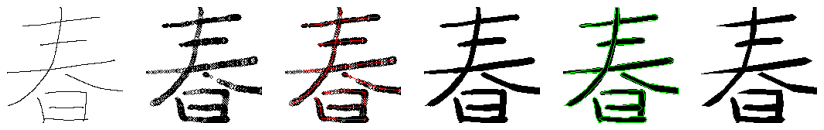

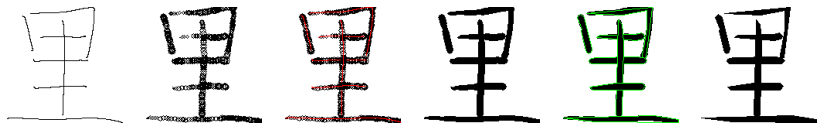

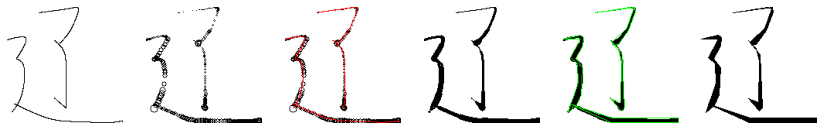

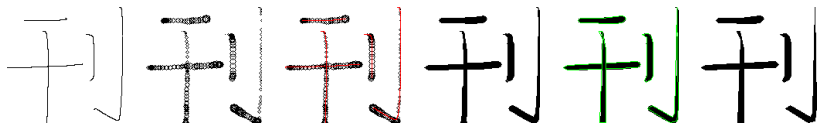

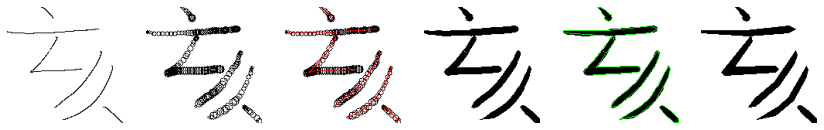

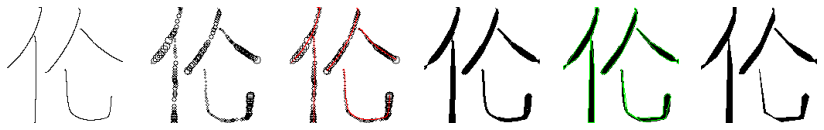

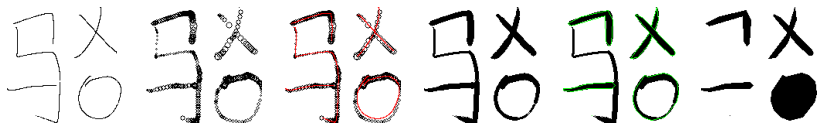

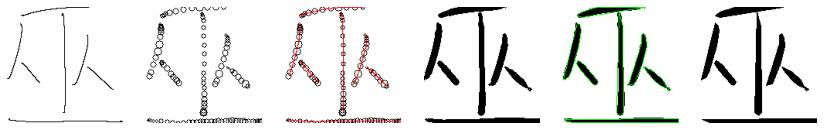

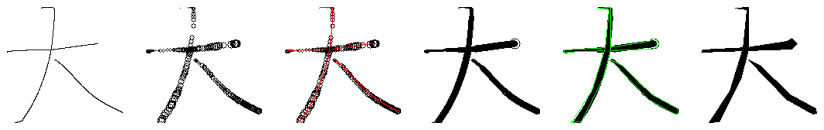

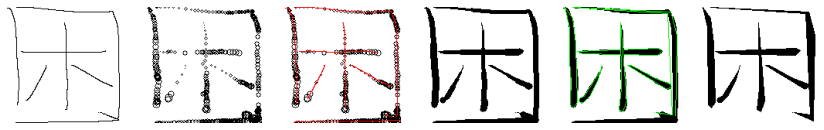

In [312]:
""" 
显示全部
"""

def draw_all():
    data_files = os.listdir('data')
    for index, data_file in enumerate(data_files):
        hand = HandWriting(f'data/{data_file}')
        hand.show()
    
draw_all()